In [148]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle
import random

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import pymesh

sys.path.append("../../")

import implicitmodules.torch as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


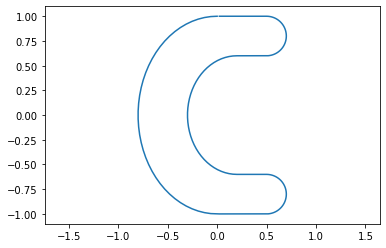

In [147]:
boudin = dm.Utilities.generate_boudin(0.8, 0.5, 1., 0.2, 0.3, 40, 20, 10, 5)
plt.plot(boudin[:, 0].numpy(), boudin[:, 1].numpy())
plt.axis('equal')
plt.show()

In [120]:
source_boudin = dm.Utilities.generate_boudin(0.8, 0.5, 1., 0.3, 40, 20, 10)
source_boudin2 = dm.Utilities.generate_boudin(0.9, 0.3, 1.1, 0.35, 40, 20, 10)

target_boudin = dm.Utilities.generate_boudin(0.63, 0.57, 0.8, 0.1, 40, 20, 10) + torch.tensor([0.2, 0.])

target_boudin3 = dm.Utilities.generate_boudin(0.75, 0.65, 1., 0.1, 40, 20, 10) + torch.tensor([0.25, 0.])
target_boudin3[:,0] = 1.3*target_boudin3[:,0]
target_boudin3[:,1] = 0.8*target_boudin3[:,1]


target_boudin3 = dm.Utilities.generate_boudin(0.48, 0.48, 1., 0.17, 40, 20, 10) + torch.tensor([0.05, 0.])
target_boudin3[:,0] = 1.6*target_boudin3[:,0]
target_boudin3[:,1] = 0.8*target_boudin3[:,1]


target_boudin = dm.Utilities.generate_boudin(0.35, 0.4, 1., 0.25, 40, 20, 10) - torch.tensor([0.1, 0.])
target_boudin[:,0] = 1.6*target_boudin[:,0]
target_boudin[:,1] = 0.8*target_boudin[:,1]

In [165]:
source_boudin = dm.Utilities.generate_boudin(0.8, 0.5, 1., 0.2, 0.3, 40, 20, 10, 5)
#source_boudin2 = dm.Utilities.generate_boudin(0.9, 0.3, 1.1, 0.35, 40, 20, 10)

target_boudin = dm.Utilities.generate_boudin(0.7, 0.6, 0.9, 0.1, 0.48, 40, 20, 10, 5)# + torch.tensor([0.2, 0.])


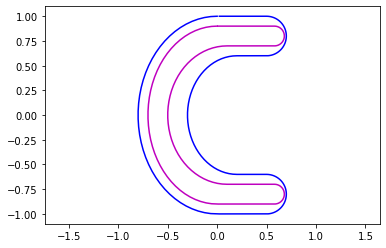

In [166]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), 'b')
#plt.plot(target_boudin3[:, 0].numpy(), target_boudin3[:, 1].numpy(), 'k')
plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy(), 'm')
plt.axis('equal')
plt.show()

In [167]:
aabb = dm.Utilities.AABB.build_from_points(source_boudin2).scale(1.2)

implicit1_points = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb, 50., shape=source_boudin2)
implicit1_rot = dm.Utilities.rot2d(0.).repeat(implicit1_points.shape[0], 1, 1)

implicit1_c = torch.zeros(implicit1_points.shape[0], 2, 1)
implicit1_c[:, 0, 0] = 1.

angles = torch.zeros(implicit1_points.shape[0], requires_grad=True)

print(implicit1_points.shape)

torch.Size([127, 2])


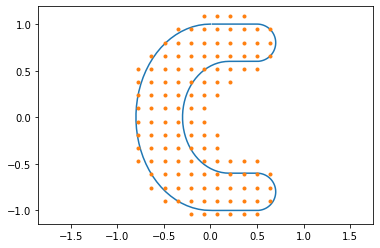

In [168]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy())
plt.plot(implicit1_points[:, 0].numpy(), implicit1_points[:, 1].numpy(), '.')
plt.axis('equal')
plt.show()

In [169]:
sigma = 0.3

global_translation = dm.DeformationModules.GlobalTranslation(2, coeff=10.)

implicit1 = dm.DeformationModules.ImplicitModule1(2, implicit1_points.shape[0], sigma, implicit1_c, nu=0.1, gd=(implicit1_points, implicit1_rot))

In [170]:
source_deformable = dm.Models.DeformablePoints(source_boudin)
target_deformable = dm.Models.DeformablePoints(target_boudin)

def precompute(init_manifold, modules, parameters):
    rot = dm.Utilities.rot2d_vec(parameters['angles']['params'][0])

    init_manifold[2].gd = (init_manifold[2].gd[0], rot)


sigmas_varifold = [0.1, 0.6]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

model = dm.Models.RegistrationModel([source_deformable], [global_translation, implicit1], [attachment], lam=1000., precompute_callback=precompute, other_parameters={'angles': {'params': [angles]}})

In [171]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit(target_deformable, 50, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(3036.8142)}
Time: 46.72171192600035
Iteration: 0
Costs
deformation=0.0398666076362133
attach=2784.30224609375
Total cost=2784.342112701386
Time: 89.57124300900068
Iteration: 1
Costs
deformation=0.8263015747070312
attach=2385.095703125
Total cost=2385.922004699707
Time: 131.2962105989991
Iteration: 2
Costs
deformation=1.3132935762405396
attach=1954.2274169921875
Total cost=1955.540710568428
Time: 174.02802815500036
Iteration: 3
Costs
deformation=1.7133245468139648
attach=1773.693603515625
Total cost=1775.406928062439
Time: 218.2291781719996
Iteration: 4
Costs
deformation=1.8841654062271118
attach=1721.305419921875
Total cost=1723.189585328102
Time: 263.97693237800013
Iteration: 5
Costs
deformation=1.6300488710403442
attach=1691.4849853515625
Total cost=1693.1150342226028
Time: 311.7116674789995
Iteration: 6
Costs
deformation=0.32890403270721436
attach=1671.618408203125
Total cost=1671

In [172]:
intermediates = {}
deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0].detach()

In [173]:
basis = model.init_manifold[2].gd[1].detach()

In [174]:
def plot_2d_basis(points, basis, **kwords):
    plt.quiver(points[:, 0].numpy(), points[:, 1].numpy(), basis[:, 0, 0].numpy(), basis[:, 1, 0].numpy(), color='blue', headlength=0., headwidth=0., **kwords)
    plt.quiver(points[:, 0].numpy(), points[:, 1].numpy(), basis[:, 0, 1].numpy(), basis[:, 1, 1].numpy(), color='red', headlength=0.,headwidth=0., **kwords)


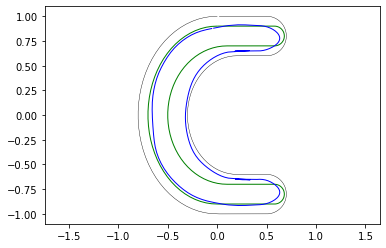

In [175]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=0.4, color='black')
plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy(), lw=1., color='green')
plt.plot(deformed[:, 0].numpy(), deformed[:, 1].numpy(), lw=1., color='blue')
plt.axis('equal')
plt.show()

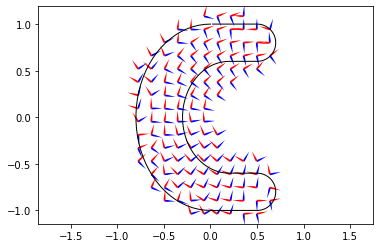

In [177]:
#%matplotlib qt5
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=1., color='black')
plot_2d_basis(implicit1_points, basis, scale=30.)
plt.axis('equal')
plt.show()


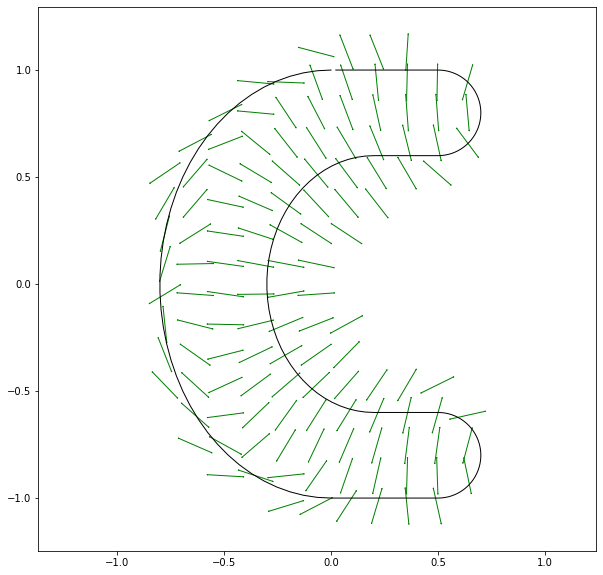

In [179]:
#%matplotlib qt5
f= plt.figure(figsize=(10,10))
ax = plt.subplot()
plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=1., color='black')
dm.Utilities.plot_C_arrows(ax, implicit1_points, implicit1_c, R=basis, c_index=0, color='green', scale=0.2)
plt.axis('equal')
plt.show()


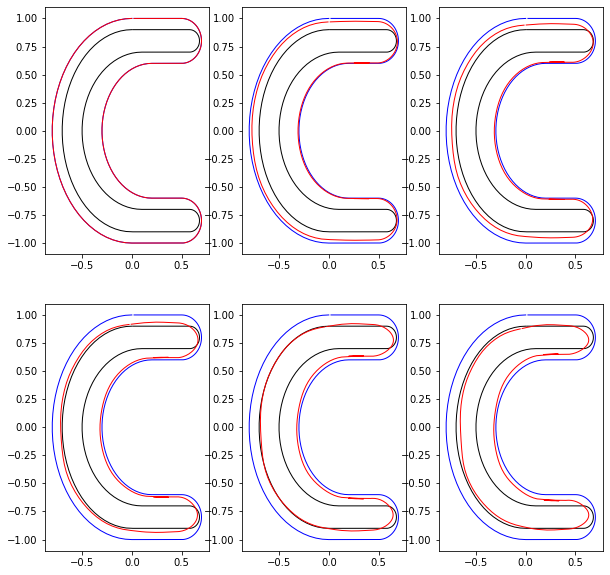

In [180]:
f= plt.figure(figsize=(10,10))
for i in range(6):
    ax = plt.subplot(2,3, i+1)
    plt.plot(source_boudin[:, 0].numpy(), source_boudin[:, 1].numpy(), lw=1., color='blue')
    plt.plot(target_boudin[:, 0].numpy(), target_boudin[:, 1].numpy(), lw=1., color='black')
    plt.plot(intermediates['states'][2*i].gd[0].detach()[:, 0].numpy(), intermediates['states'][2*i].gd[0].detach()[:, 1].numpy(), lw=1., color='red')

    

In [66]:
import pickle

In [67]:
res = {'model' : model, 'target':target_boudin}

In [68]:
pickle.dump(res, open('/home/gris/Results/ImplicitModules/bentrod/exp3.p', "wb"))

In [9]:
res_load = pickle.load( open( "/home/gris/Results/ImplicitModules/bentrod/exp1.p", "rb" ) )